In [1]:
from fmz import *
import pandas as pd

def get_day(timestamp):
    '返回月份 与 日'
    format_time = time.localtime(timestamp/1000)
    return (format_time[0],format_time[1],format_time[2])

In [2]:
class settings:
    def __init__(self,start = "2019-06-10 00:00:00",end="2019-07-10 00:00:00",eid = "Bitfinex",currency ="BTC_USD",balance = "10000",stocks = "1",period = "1d"):
        self.setting_str = default_setting
        self.settings = {
            "start":start,
            "end"  :end,
            "eid"  :eid,
            "currency":currency,
            "balance":str(balance),
            "stocks":str(stocks),
            "period":period
        }
        self.setting_str = self.setting_str.replace("2019-06-10 00:00:00",self.settings["start"])
        self.setting_str = self.setting_str.replace("2019-08-10 00:00:00",self.settings["end"])
        self.setting_str = self.setting_str.replace("Bitfinex",self.settings["eid"])
        self.setting_str = self.setting_str.replace("BTC_USD",self.settings["currency"])
        self.setting_str = self.setting_str.replace("10000",self.settings["balance"])
        self.setting_str = self.setting_str.replace("stocks:3","stocks:{}".format(float(self.settings["stocks"])))
        self.setting_str = self.setting_str.replace("1m",self.settings["period"])
    def export(self):
        return self.setting_str

In [3]:
class strategy:
    def __init__(self):
        pass
    def init(self,PRINT = False):
        self.task = VCtx(self.setting)
        self.init_account = exchange.GetAccount()
        self.realizible_profit = 0
        if PRINT:
            print("Strategy Name:",self.name)
            print("Setting:", self.setting)
        #print(self.setting)
        #print("初始账户信息:",self.init_account)
    def main(self):
        while True:
            self.onTick()
            Sleep(1000)
    def exit_f(self):
        pass
    def format_outcome(self):
        for key in self.outcome:
            if key == "RuntimeLogs":
                continue
            if type(self.outcome[key]) != type([]) and type(self.outcome[key]) != type({}):
                print(key, self.outcome[key])
            elif type(self.outcome[key]) == type({}):
                print(key)
                for small_key in self.outcome[key]:
                    print('   ', small_key, self.outcome[key][small_key])
            else:
                print(key)
                for item in self.outcome[key]:
                    for small_key in item:
                        print('   ', small_key, item[small_key])
        #for Log in self.outcome['RuntimeLogs']:
            #print(Log)
    def run(self,PRINT = False):
        '''运行回测然后得到收益'''
        self.init(PRINT)
        try:
            self.main()
        except EOFError:
            #print("回测结束\n")
            self.exit_f()
            df = self.task.Join(True);
            self.task.Show();
#             df.to_csv("outcome.csv",sep=',');
#             self.outcome = json.loads(self.task.Join())
#             for Log in self.outcome['RuntimeLogs']:
#                 Log[1] = get_day(Log[1])
#                 #print(Log)
#             Snapshort = self.outcome['Snapshort'][0]
#             balance_change = Snapshort['Balance'] - self.init_account['Balance']
#             stock_change = Snapshort['Stocks'] - self.init_account['Stocks']
#             self.realizible_profit = balance_change + stock_change * Snapshort['Symbols']['BTC_USD_Bitfinex']['Last'] - Snapshort['Commission']
#             self.commission = float(Snapshort['Commission'])

In [4]:
class Dual_Thrust(strategy):
    def __init__(self):
        self.name = 'DualThrust'
        self.param = {
            "N":5,
            "k1":0.9,
            "k2":0.5,
            "p":1
        }
    def main(self):
        Histroy_record = exchange.GetRecords()
#         print("Histroy_record", Histroy_record);
        dopen = Histroy_record[-1].Open  # 每日的开盘价
        LastDay = get_day(Histroy_record[-1].Time / 1000)  # 上一次获取行情的日期
        Nperiod = Histroy_record[-1 * self.param['N'] - 1:][:-1]  # 前N日的K数据
        Track = self.get_track(Nperiod,dopen)  # 获取上下轨数据
        LastState = 'IDLE'
        while True:
            ticker = exchange.GetTicker()
#             print(time.strftime("%b %d %Y %H:%M:%S",time.localtime(int(str(ticker['Time'])[:-3]))))
#             print("ticker", ticker);
            NowPrice = ticker.Last  # 当前市场最后成交价格
            NowDay = get_day(ticker.Time)  # 当前日期            
            if (NowDay != LastDay):
                # 进入了新的一天，重新更新前N天数据与今日开盘价,与今日上下轨点数
                Histroy_record = exchange.GetRecords(PERIOD_D1)
#                 print("Histroy_record d1", Histroy_record);
                #for tick in Histroy_record:
                #    print(time.strftime("%b %d %Y %H:%M:%S",time.localtime(int(str(tick['Time'])[:-3]))))
                Nperiod = Histroy_record[-1 * self.param['N'] - 1:][:-1]
                
#                 print("Nperiod1", Nperiod);
                dopen = Histroy_record[-1].Open
                Track = self.get_track(Nperiod,dopen)
                Log(NowDay, ':', Log(exchange.GetAccount()))
            if (NowPrice > Track['uptrack'] and LastState != 'LONG'):
                Log('当前市价格', NowPrice, '突破做多触发价:', Track['downtrack'])
                # cancel_pending_orders(ORDER_TYPE_SELL) # 撤回所有卖单
                if LastState == "IDLE":
                    exchange.Buy(ticker.Sell * 1.001, self.param['p'])
                else:
                    exchange.Buy(ticker.Sell * 1.001, 2 * self.param['p'])
                    # days_operation = True
                LastState = 'LONG'
            if (NowPrice < Track['downtrack'] and LastState != 'SHORT'):
                Log('当前市价格', NowPrice, '突破做空触发价:', Track['downtrack'])
                # cancel_pending_orders(ORDER_TYPE_BUY) # 撤回所有买单
                if LastState == "IDLE":
                    exchange.Sell(ticker.Buy * 0.999, self.param['p'])
                else:
                    exchange.Sell(ticker.Buy * 0.999, 2 * self.param['p'])
                LastState = 'SHORT'
            LastDay = NowDay  # 更新上次获取行情的日期
    def get_track(self,Nperiod,dopen):
        
#         print("Nperiod", Nperiod);
        '获得上下轨点数'
        HH = max([day.High for day in Nperiod])
        LC = min([day.Close for day in Nperiod])
        HC = max([day.Close for day in Nperiod])
        LL = min([day.Low for day in Nperiod])
        RANGE = max(HH - LC, HC - LL)
        return {'uptrack': dopen + self.param['k1'] * RANGE, 'downtrack': dopen - self.param['k2'] * RANGE}

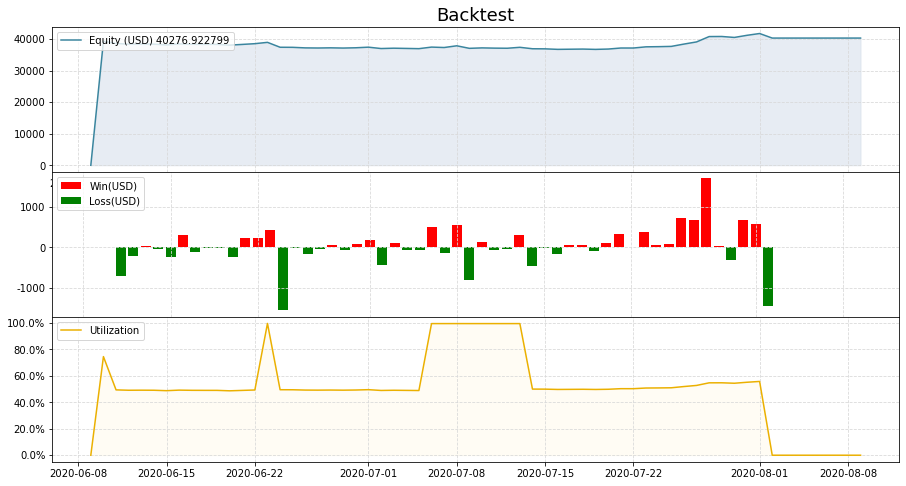

In [5]:
# strategy = Dual_Thrust();
strategy = Dual_Thrust();
strategy.setting = '''backtest
start: 2020-06-10 00:00:00
end: 2020-08-10 00:00:00
period: 1h
exchanges: [{"eid":"OKEX","currency":"BTC_USDT","balance":10000,"stocks":3}]'''
strategy.run()